In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import sys
from haversine import haversine

In [29]:
labels = gpd.read_file('data/processed-labels/seattle.shp')

In [30]:
labels

,label_id,label_type,severity,gsv_panora,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry
0,85055,CurbRamp,1.0,NjPAkwTxWsayAq3kCugvdA,1,107.750000,-15.62500,270.556610,0.907036,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618599,-122.332787,POINT (-122.33279 47.61860)
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.87500,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617805,-122.331886,POINT (-122.33189 47.61781)
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617512,-122.331833,POINT (-122.33183 47.61751)
3,85060,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.50000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617519,-122.331879,POINT (-122.33188 47.61752)
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.00000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617638,-122.332047,POINT (-122.33205 47.61764)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195538,231270,CurbRamp,1.0,R-sTl5O6sOdVPurgTWy3EQ,1,332.468750,-35.00000,215.130295,-0.157570,155af0a9-4149-4436-8aa3-7573e160036d,47.540771,-122.267258,POINT (-122.26726 47.54077)
195539,231285,NoSidewalk,5.0,N5MrAAtHZO2JGXUrYAYnSQ,3,0.890625,-11.65625,179.161057,-5.825714,155af0a9-4149-4436-8aa3-7573e160036d,47.552292,-122.263443,POINT (-122.26344 47.55229)
195540,231338,CurbRamp,1.0,d3oBrJ-nDtKMwlE7svc6pg,1,253.562500,-35.00000,177.959915,-0.962440,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563271,-122.281792,POINT (-122.28179 47.56327)
195541,231339,CurbRamp,1.0,AOIBJ12BjFanDJF1Ark05Q,1,110.312500,-35.00000,179.365723,-1.093400,3ac3d4de-a70a-48ec-b46e-498d6e26ee6c,47.563469,-122.281654,POINT (-122.28165 47.56347)


In [90]:
labels['label_id'].nunique()

195543

In [13]:
q1 = gpd.read_file('data/attributesWithLabels_q01.json')

In [67]:
# labels.cx[-122.41765594:-122.32900238, 47.61501312:47.73071671]
box = labels.total_bounds.tolist()

In [68]:
box

[-122.41842651367188,
 47.49544906616211,
 -122.23896026611328,
 47.73453140258789]

Text(-122.323, 47.647, '(-122.323, 47.649)')

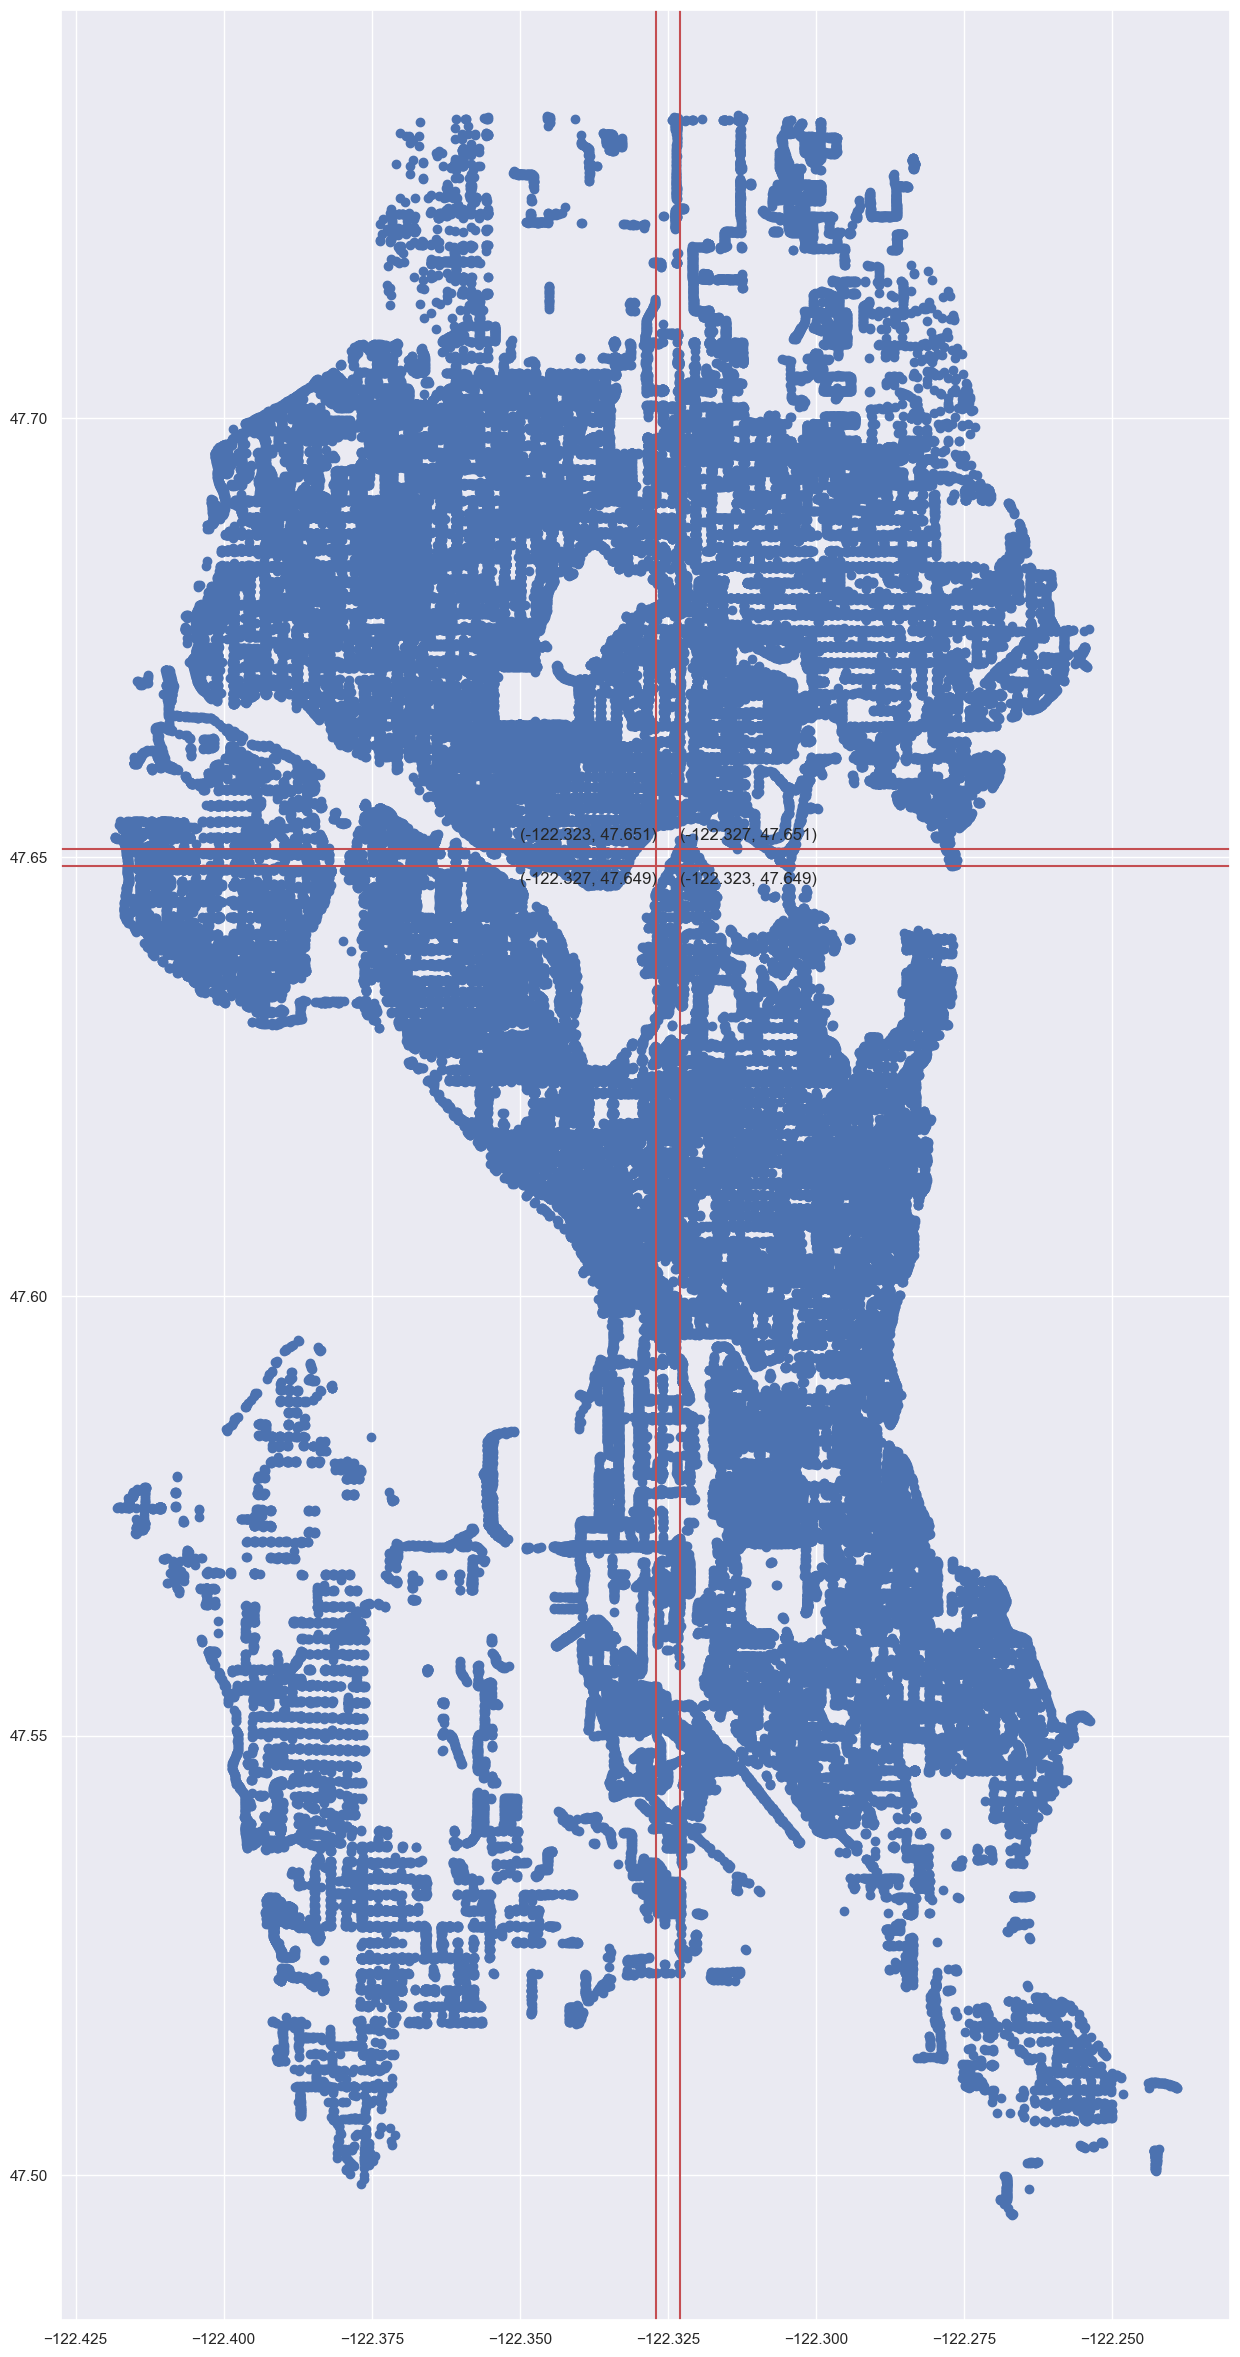

In [61]:
labels.plot()
# #make the plot bigger
# plt.rcParams['figure.figsize'] = [30, 30]
# #draw a line at 47.66 and 47.64
plt.axhline(y=47.651, color='r', linestyle='-')
plt.axhline(y=47.649, color='r', linestyle='-')
# #draw a line at -122.327 and -122.323
plt.axvline(x=-122.327, color='r', linestyle='-')
plt.axvline(x=-122.323, color='r', linestyle='-')
#annotate the intersection of the lines with the coordinates, offset by 0.001
plt.annotate('(-122.327, 47.651)', xy=(-122.327, 47.651), xytext=(-122.323, 47.652))
plt.annotate('(-122.323, 47.651)', xy=(-122.323, 47.651), xytext=(-122.350, 47.652))
plt.annotate('(-122.327, 47.649)', xy=(-122.327, 47.649), xytext=(-122.350, 47.647))
plt.annotate('(-122.323, 47.649)', xy=(-122.323, 47.649), xytext=(-122.323, 47.647))


In [62]:
# store the intersection coordinates in a list
intersections = [(-122.327, 47.651), (-122.323, 47.651), (-122.327, 47.649), (-122.323, 47.649)]

In [69]:
#create four boxes with the intersections and the box coordinates
box1 = [intersections[0][0], intersections[0][1], box[2], box[3]]
box2 = [box[0], intersections[1][1], intersections[1][0], box[3]]
box3 = [intersections[2][0], box[1], box[2], intersections[2][1]]
box4 = [box[0], box[1], intersections[3][0], intersections[3][1]]

In [120]:
print(box1[1], box3[1])

47.651 47.49544906616211


In [133]:
#plot the boxes
q1 = labels.cx[-122.323 : -122.418, 47.734: 47.649]
q2 = labels.cx[-122.239 : -122.323, 47.734: 47.649]
q3 = labels.cx[-122.239 : -122.323, 47.651: 47.495]
q4 = labels.cx[-122.323 : -122.418, 47.651: 47.495]

In [134]:
#save q1 q2 q3 q4 to shapefiles
q1.to_file('data/processed-labels/q1.shp')
q2.to_file('data/processed-labels/q2.shp')
q3.to_file('data/processed-labels/q3.shp')
q4.to_file('data/processed-labels/q4.shp')

In [142]:
q4

,label_id,label_type,severity,gsv_panora,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry
0,85055,CurbRamp,1.0,NjPAkwTxWsayAq3kCugvdA,1,107.750000,-15.625000,270.556610,0.907036,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.618599,-122.332787,POINT (-122.33279 47.61860)
1,85057,Obstacle,2.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,38.375000,-21.875000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617805,-122.331886,POINT (-122.33189 47.61781)
2,85059,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.500000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617512,-122.331833,POINT (-122.33183 47.61751)
3,85060,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,131.187500,-24.500000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617519,-122.331879,POINT (-122.33188 47.61752)
4,85062,CurbRamp,1.0,f_Mibt-6nJU7HTN7kx5ZGQ,1,257.187500,-35.000000,164.133438,0.335564,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.617638,-122.332047,POINT (-122.33205 47.61764)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195460,84976,CurbRamp,1.0,-ckGXVaLK1TcDDw6tazt5Q,1,11.375000,-15.125000,310.992859,-0.179024,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.615276,-122.339600,POINT (-122.33960 47.61528)
195461,84978,CurbRamp,1.0,-ckGXVaLK1TcDDw6tazt5Q,1,278.750000,-21.687500,310.992859,-0.179024,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.615166,-122.339836,POINT (-122.33984 47.61517)
195462,84989,CurbRamp,1.0,d4y9dqjILO2W1rD6gJeWdA,1,333.062500,-31.625000,44.068935,1.698112,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.615898,-122.341118,POINT (-122.34112 47.61590)
195463,84993,CurbRamp,1.0,kc_ZtnbGc7SLcZLOXdSb3w,2,8.241072,-8.214286,311.037811,-0.420952,4f2a3a9a-a5d5-4d57-b2d1-6be61a6c2184,47.616055,-122.340942,POINT (-122.34094 47.61605)
